In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import muon as mu
import scvi
import glob
import matplotlib.pyplot as plt
from scipy import sparse

sc.settings.verbosity = 3
sc.settings.n_jobs = 16
scvi.settings.num_threads = 16
scvi.train.Trainer(accelerator = 'auto')
%config InlineBackend.figure_format='retina'

Global seed set to 0
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Preprocess Anndata objects

## Prepare public data

In [3]:
h5ad_paths = sorted(glob.glob("/Users/pax/OneDrive - Karolinska Institutet/PhD/Injury_atlas/Anndata/*"))

In [5]:
def h5ad_sce(file_path):
    adata = sc.read_h5ad(file_path)
    
    # format the data to adopt the Anndata format fro SCE
    del adata.uns
    del adata.obsm
    adata.layers["counts"] = adata.X.copy()
    adata.var['mt'] = adata.var_names.str.startswith('mt')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata.obs['Modality'] = "Expression"
    adata.obs['Tissue'] = 'DRG'
    adata.obs['Technology'] = '10x_GEX'
    adata.obs["celltype_scanvi"] = "Unknown"
    return adata

In [6]:
adatas1 = list(map(h5ad_sce, h5ad_paths))
adatas1[1].obs.Technology = "inDrops"
adatas1[1].obs.celltype_scanvi = adatas1[1].obs.CellType

adatas1[0].obs.celltype_scanvi[adatas1[0].obs.CellType.isin(['SGC', 'Schwann', 'Macrophage', 'Pericytes','Endothelial', 'Smooth Muscle', 'Connective Tissue'])] =\
    adatas1[0].obs.CellType[adatas1[0].obs.CellType.isin(['SGC', 'Schwann', 'Macrophage', 'Pericytes','Endothelial', 'Smooth Muscle', 'Connective Tissue'])]
adatas1[0].obs.celltype_scanvi[adatas1[0].obs.celltype_scanvi == 'Schwann'] = 'Schwann_M'

adatas1[2].obs['Source'] = 'Sharma'
adatas1[2].obs['Sex'] = 'female'
adatas1[2].obs["Conditions"] = "Naive"
adatas1[2].obs["Time"] = "0day"
adatas1[2].obs["Strains"] = "C57"
adatas1[2].obs["Age"] = "Old"

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16724/925604411.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatas1[0].obs.celltype_scanvi[adatas1[0].obs.CellType.isin(['SGC', 'Schwann', 'Macrophage', 'Pericytes','Endothelial', 'Smooth Muscle', 'Connective Tissue'])] =\
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16724/925604411.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adatas1[0].obs.celltype_scanvi[adatas1[0].obs.celltype_scanvi == 'Schwann'] = 'Schwann_M'


## Patch-seq prep

In [7]:
count = pd.read_table("/Users/pax/OneDrive - Karolinska Institutet/PhD/Injury_atlas/Notebook/Patch-seq/GSE168032_tpm_counts.txt", sep="\t", index_col=0)
samp_tab = pd.read_table("/Users/pax/OneDrive - Karolinska Institutet/PhD/Injury_atlas/Notebook/Patch-seq/GSE168032_sampleTable_matrix.txt", sep="\t", index_col=0)

In [8]:
count = count.set_index('gene_symbol').iloc[:,2:]
count = count.T
count.sort_index(inplace=True)

In [9]:
patch_adata = sc.AnnData(count, obs=samp_tab)
patch_adata.var_names_make_unique()
sc.pp.filter_genes(patch_adata, min_cells=20)

filtered out 33158 genes that are detected in less than 20 cells


/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16724/1575633092.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  patch_adata = sc.AnnData(count, obs=samp_tab)
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:
gene_len = patch_adata.to_df().sum(axis=0)
gene_len = gene_len.reindex(patch_adata.var.index).dropna()
assert (patch_adata.var.index == gene_len.index).sum() == patch_adata.shape[1]
patch_adata.X = patch_adata.X / gene_len.values * np.median(gene_len.values)
# round to integer
patch_adata.X = np.rint(patch_adata.X)

In [11]:
patch_adata.layers["counts"] = patch_adata.X.copy()
patch_adata.var['mt'] = patch_adata.var_names.str.startswith('mt')
sc.pp.calculate_qc_metrics(patch_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
patch_adata.obs['Modality'] = "Expression"
patch_adata.obs['Tissue'] = 'DRG'
patch_adata.obs['Technology'] = 'PatchSeq'
patch_adata.obs["celltype_scanvi"] = "Unknown"
patch_adata.obs["Conditions"] = "Naive"
patch_adata.obs["Time"] = "0day"
patch_adata.obs["Strains"] = "C57"
patch_adata.obs["Age"] = "Old"
patch_adata.obs["Sex"] = "male"
patch_adata.obs["Source"] = "Parpaite"

In [12]:
adatas1 = adatas1 + [patch_adata]

## Prepare Lab data

### Multiome

In [13]:
dir_list = sorted(glob.glob('/Users/pax/OneDrive - Karolinska Institutet/PhD/10x_multi_DRG/data/MO*'))
dir_list.pop(dir_list.index('/Users/pax/OneDrive - Karolinska Institutet/PhD/10x_multi_DRG/data/MO_22_005'))
dir_list.pop(dir_list.index('/Users/pax/OneDrive - Karolinska Institutet/PhD/10x_multi_DRG/data/MO_22_007'))
dir_list = dir_list[2:]
dir_name = [i.split('/')[-1] for i in dir_list]

In [14]:
condition_list = [
    'C57_CCI_14day_Old_Lab_female_Paired',
    'C57_Naive_0day_Old_Lab_female_Paired',
    'C57_Naive_0day_Young_Lab_female_Paired',
    'C57_Naive_0day_Young_Lab_male_Paired',
]

In [15]:
condition_dict = dict(zip(dir_name, condition_list))

In [16]:
batch_id_dict = {1:'MO_22_003', 2:'MO_22_004', 3:'MO_22_006',4:'MO_22_008'}

In [17]:
# The count matrices of the 10X multiomics were preprocessed with cellranger-arc to aggregate the peaks.
# Here the aggregated matrix was splitted back into multiple matrices according to the original expreiments.
def read_adata_multi(dir_path):
    adata = scvi.data.read_10x_multiome(f'{dir_path}/raw_feature_bc_matrix')
    adata.obs['batch_name'] = adata.obs['batch_id'].map(batch_id_dict)
    adatas = [adata[adata.obs['batch_id'] == i] for i in adata.obs.batch_id.unique()]
    return adatas

In [18]:
def pp_adata_multi(adata):
    meta = pd.read_csv(f'/Users/pax/OneDrive - Karolinska Institutet/PhD/10x_multi_DRG/data/{adata.obs.batch_name.unique()[0]}/meta.csv', index_col=0)
    meta.index = meta.index.str.split('-').str[0]
    adata.obs = adata.obs.join(meta)
    adata.var_names_make_unique()
    sc.pp.filter_genes(adata, min_cells=3)
    adata = adata[adata.obs.log1p_n_peaks_by_counts > 4]
    adata = adata[adata.obs.log1p_n_genes_by_counts > 4]
    adata = adata[adata.obs.log1p_n_peaks_by_counts < 9]
    adata = adata[adata.obs.log1p_n_genes_by_counts < 9]
    adata.var['mt'] = adata.var_names.str.startswith('mt-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.pct_counts_mt < 1.5]
    adata = adata[adata.obs.total_counts < 20000]
    adata.obs['tmp'] = condition_dict[adata.obs.batch_name.unique()[0]]
    adata.obs[['Strains','Conditions','Time','Age','Source','Sex','Modality']] = adata.obs['tmp'].str.split('_', expand=True)
    del adata.obs['tmp']
    id = adata[adata[: , 'Uty'].X > 0, :].obs_names
    adata.obs.Sex.loc[id] = 'male'
    adata.layers["counts"] = adata.X.copy()
    adata.obs['Tissue'] = 'DRG'
    adata.obs['Technology'] = '10x_Multiome'
    adata.obs['Source'] = "Lab_Multiome"
    return adata

In [19]:
adatas2 = list(map(pp_adata_multi, read_adata_multi('/Users/pax/OneDrive - Karolinska Institutet/PhD/Injury_atlas/MO_22_AGGR/outs')))

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/scvi/data/_read.py:76: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(data.tocsr(), var=features, obs=cell_annot)
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


filtered out 10266 genes that are detected in less than 3 cells


/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16724/2913212283.py:11: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('mt-')
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16724/2913212283.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['tmp'] = condition_dict[adata.obs.batch_name.unique()[0]]
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16724/2913212283.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

filtered out 10725 genes that are detected in less than 3 cells


/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16724/2913212283.py:11: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('mt-')
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16724/2913212283.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['tmp'] = condition_dict[adata.obs.batch_name.unique()[0]]
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16724/2913212283.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

filtered out 11194 genes that are detected in less than 3 cells


/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16724/2913212283.py:11: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('mt-')
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16724/2913212283.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['tmp'] = condition_dict[adata.obs.batch_name.unique()[0]]
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16724/2913212283.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

filtered out 12835 genes that are detected in less than 3 cells


/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16724/2913212283.py:11: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('mt-')
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16724/2913212283.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['tmp'] = condition_dict[adata.obs.batch_name.unique()[0]]
/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16724/2913212283.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

### SS3

In [20]:
adata_ss3 = sc.read_h5ad("./adata_drg_ss3_WT.h5ad")

In [21]:
adata_ss3.obs['Source'] = "Lab_SS3"
adata_ss3.obs['Modality'] = "Expression"
adata_ss3.obs['Conditions'] = "Naive"
adata_ss3.obs['Time'] = "0day"
adata_ss3.obs['Tissue'] = 'DRG'
adata_ss3.obs['Technology'] = 'SS3'
adata_ss3.obs['Strains'] = 'C57'
adata_ss3.obs['Age'] = 'Old'
adata_ss3.obs['Sex'] = 'female'
id = adata_ss3[adata_ss3[: , 'Uty'].X > 0, :].obs_names
adata_ss3.obs.Sex.loc[id] = 'male'
del adata_ss3.layers["umi"]
del adata_ss3.layers["read"]
# adata_ss3.obs["celltype_scanvi"] = "Unknown"

/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_16724/541738268.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_ss3.obs.Sex.loc[id] = 'male'


# Concatenate Anndata and prepare data

In [22]:
# concate the Gene Expression modality
rna_andata = sc.concat((adatas1 + [adata_ss3]), join='outer')

# concate the Paired modality
multi_adata = sc.concat(adatas2, join='outer')

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [54]:
# We can now use the organizing method from scvi to concatenate these anndata
adata_mvi = scvi.data.organize_multiome_anndatas(multi_anndata=multi_adata, rna_anndata=rna_andata)
adata_mvi.obs_names_make_unique()

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWar

In [55]:
del adata_mvi.layers['logcounts']

In [56]:
# Change datatype of "Time" column in adata.obs to "category"
adata_mvi.obs.Time = adata_mvi.obs.Time.astype('category')
adata_mvi.obs.Time = adata_mvi.obs.Time.cat.reorder_categories(['0day','0.25day','0.5day','1day','1.5day','2day','3day','7day','14day','28day','60day','90day'])

In [57]:
# fix missing modality in andata.var
adata_mvi.var['modality'] = 'Unknown'
adata_mvi.var.modality[adata_mvi.var_names.str.contains(":")] = 'Peaks'
adata_mvi.var.modality[~adata_mvi.var_names.str.contains(":")] = 'Gene Expression'

In [59]:
# keelp only "modality" column in andata.var
adata_mvi.var = adata_mvi.var[['modality']]

In [60]:
adata_mvi = adata_mvi[:,~adata_mvi.var_names.str.startswith('rRNA')]
adata_mvi = adata_mvi[:,~adata_mvi.var_names.str.contains('ENSMUSG')]

In [61]:
# sort features so that Gene Expression modality comes first
adata_mvi = adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()

In [63]:
# # filter features
print(adata_mvi.shape)
sc.pp.filter_genes(adata_mvi, min_cells=20)
print(adata_mvi.shape)

(228642, 45474)
filtered out 2370 genes that are detected in less than 20 cells
(228642, 43104)


In [64]:
adata_mvi.var.modality.value_counts(dropna=False)

Gene Expression    21917
Peaks              21187
Name: modality, dtype: int64

<Axes: ylabel='Frequency'>

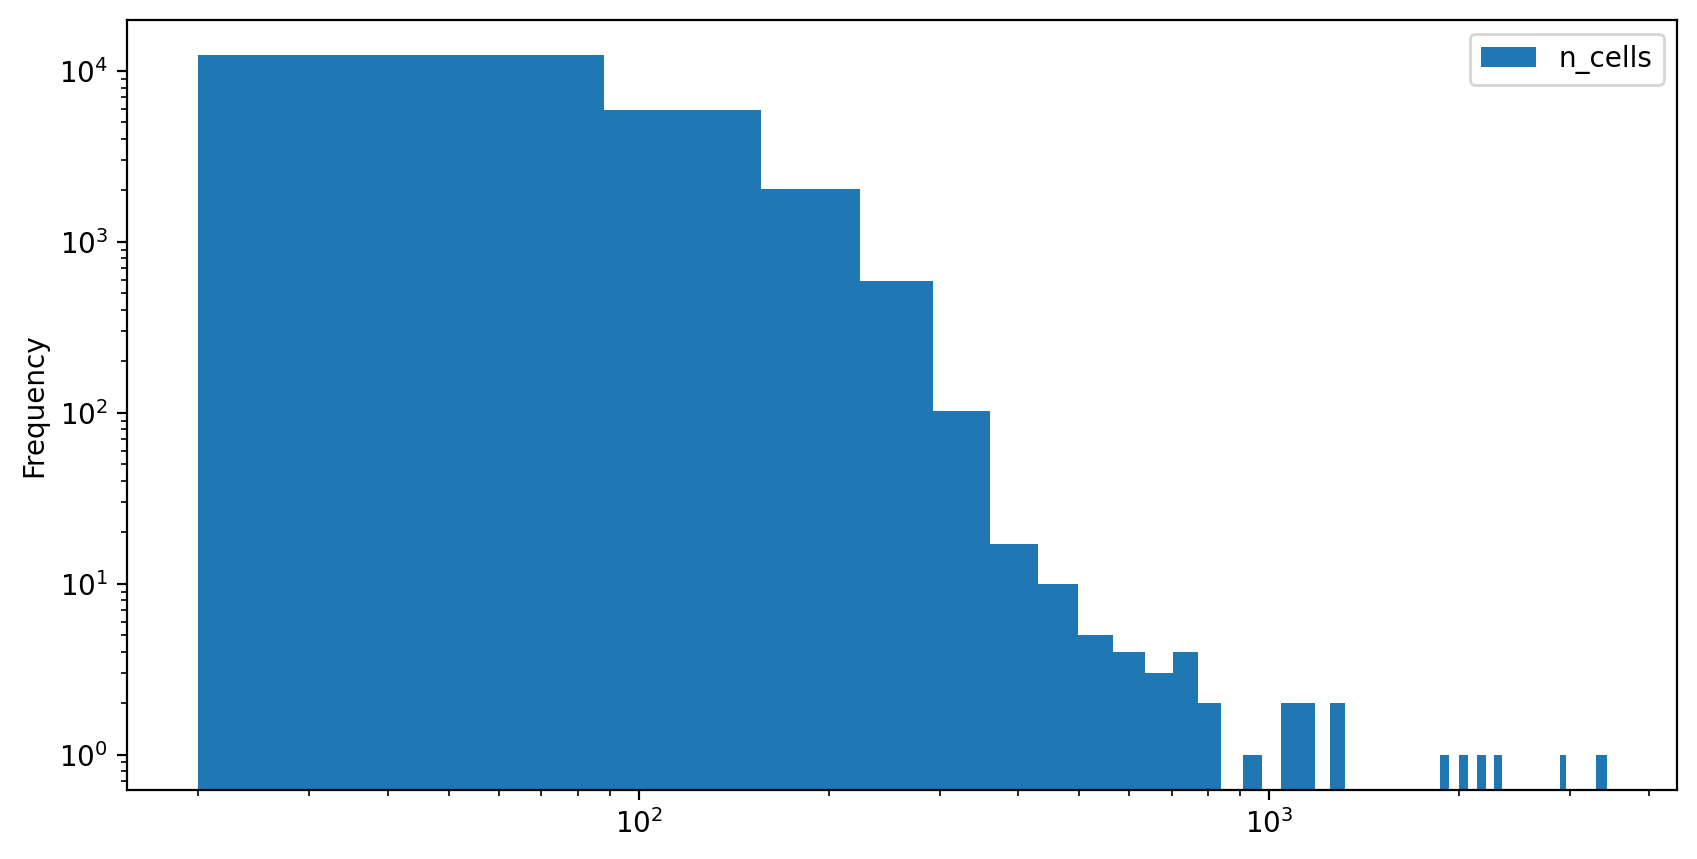

In [65]:
adata_mvi.var[adata_mvi.var.modality == 'Peaks'].plot(kind='hist', bins=50, logy=True, logx=True, figsize=(10,5))

In [66]:
atac_features = adata_mvi.var[(adata_mvi.var.modality == 'Peaks') & (adata_mvi.var_names.str.startswith("chr")) & (adata_mvi.var.n_cells < 1000)].index.tolist()
gene_features = adata_mvi.var[(adata_mvi.var.modality == 'Gene Expression') & (adata_mvi.var.n_cells > 85)].index.tolist()

In [67]:
adata_mvi = adata_mvi[:,gene_features + atac_features].copy()

In [68]:
adata_mvi.var.modality.value_counts(dropna=False)

Peaks              21130
Gene Expression    20102
Name: modality, dtype: int64

In [69]:
adata_mvi.obs = adata_mvi.obs[['Conditions','Strains','Time','Sex','Age',
                               'Technology','Tissue','Source','modality',
                               'mixed_currents','current_Type_1','current_Type_2']].copy()

In [70]:
adata_mvi.write_h5ad('./Results_h5ad/02_adata_mvi.h5ad')

# Train MULTIVI model

In [2]:
adata_mvi = sc.read_h5ad('./Results_h5ad/02_adata_mvi.h5ad')

In [72]:
# setup adata for MULTIVI model
scvi.model.MULTIVI.setup_anndata(adata_mvi, batch_key="modality",
                                 categorical_covariate_keys=['Source','Conditions','Strains','Time','Sex','Age','Technology']
                                 )

In [73]:
# initialize the MULTIVI model
mvi = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_mvi.var["modality"] == "Gene Expression").sum(),
    n_regions=(adata_mvi.var["modality"] == "Peaks").sum()
)
mvi.view_anndata_setup()

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Anndata setup with scvi-tools version 0.20.3.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'modality',
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['Source', 'Conditions', 'Strains', 'Time', 'Sex', 'Age', 'Technology'],
│   'continuous_covariate_keys': None,
│   'protein_expression_obsm_key': None,
│   'protein_names_uns_key': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   2    │
│         n_cells          │ 228642 │
│ n_extra_categorical_covs │   7    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 41232  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │ expression │          0          │
│                       │   paired   │          1          │
└───────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │ expression │          0          │
│                       │   paired   │          1          │
└───────────────────────┴────────────┴─────────────────────┘

             extra_categorical_covs State Registry              
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃  Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│    adata.obs['Age']     │     Old      │          0          │
│                         │    Young     │          1          │
│                         │              │                     │
│ adata.obs['Conditions'] │     CCI      │          0          │
│                         │     CFA      │          1          │
│                         │    Crush     │          2          │
│                         │     DRC      │          3          │
│                         │    Naive     │          4          │
│                         │  Paclitaxel  │          5          │
│                         │     ScNT     │          6          │
│                         │     Sham     │          7          │
│                         │     SpNT     │          8          │
│                         │              │                     │
│    adata.obs['Sex']     │    female    │          0          │
│                         │     male     │          1          │
│                         │              │                     │
│   adata.obs['Source']   │   Avraham    │          0          │
│                         │ Lab_Multiome │          1          │
│                         │   Lab_SS3    │          2          │
│                         │   Parpaite   │          3          │
│                         │   Renthal    │          4          │
│                         │    Sharma    │          5          │
│                         │     Wang     │          6          │
│                         │    Zhang     │          7          │
│                         │              │                     │
│  adata.obs['Strains']   │     C57      │          0          │
│                         │  Mrgprd-cre  │          1          │
│                         │     Pirt     │          2          │
│                         │              │                     │
│ adata.obs['Technology'] │   10x_GEX    │          0          │
│                         │ 10x_Multiome │          1          │
│                         │   PatchSeq   │          2          │
│                         │     SS3      │          3          │
│                         │   inDrops    │          4          │
│                         │              │                     │
│    adata.obs['Time']    │     0day     │          0          │
│                         │   0.25day    │          1          │
│                         │    0.5day    │          2          │
│                         │     1day     │          3          │
│                         │    1.5day    │          4          │
│                         │     2day     │          5          │
│                         │     3day     │          6          │
│                         │     7day     │          7          │
│                         │    14day     │          8          │
│                         │    28day     │          9          │
│                         │    60day     │         10          │
│                         │    90day     │         11          │
│                         │              │                     │
└─────────────────────────┴──────────────┴─────────────────────┘

In [27]:
# train the model
mvi.to_device(device='mps') 
mvi.train(early_stopping=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


/var/folders/pg/_gfvzhnj3zxc0lm8r3cm3jc00000gn/T/ipykernel_56107/415402391.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


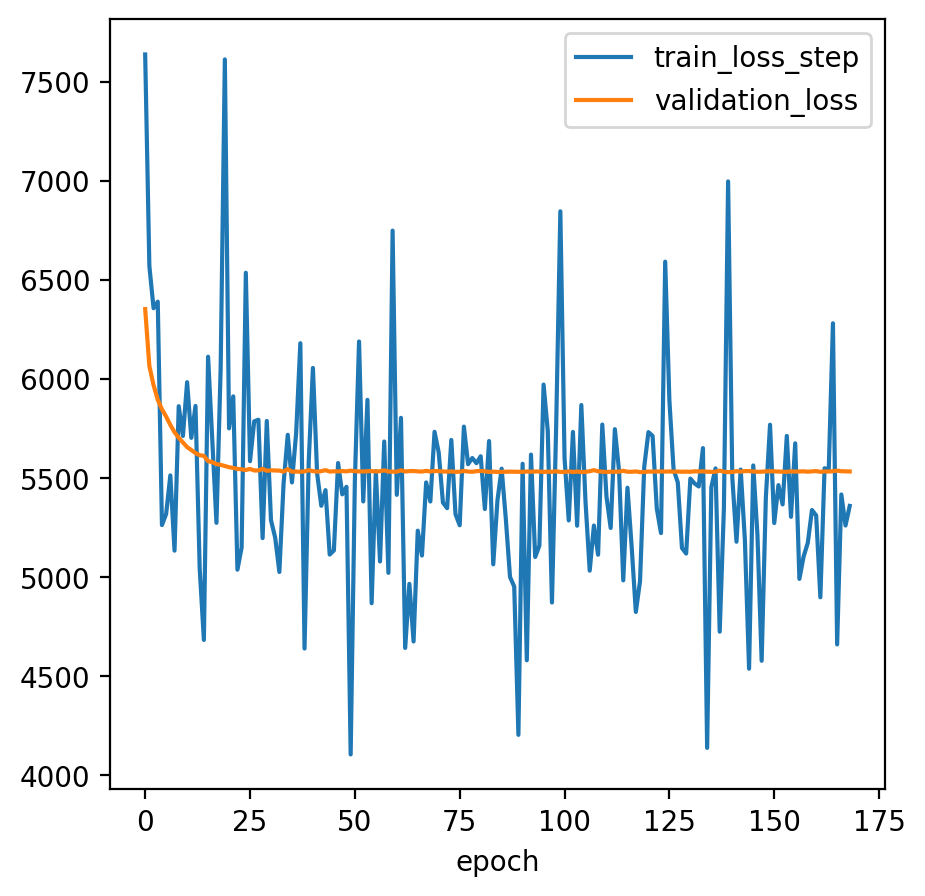

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
mvi.history['train_loss_step'].plot(ax=ax, label='train loss')
mvi.history['validation_loss'].plot(ax=ax, label='validation loss')
fig.show()

In [ ]:
mvi.save('./multivi_model', save_anndata=True, overwrite=True)

In [ ]:
adata_mvi.obsm["X_multiVI"] = mvi.get_latent_representation()

In [ ]:
adata_mvi.write_h5ad('./Results_h5ad/02_adata_mvi_trained.h5ad')

# Load the model and get the latent representation

In [2]:
mvi = scvi.model.MULTIVI.load('./multivi_model')

INFO     File ./multivi_model/model.pt already downloaded                                                          


/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [ ]:
mdata = mu.MuData({'rna':adata_mvi[:, adata_mvi.var["modality"] == "Gene Expression"].copy(), 
               'atac':adata_mvi[:, adata_mvi.var["modality"] == "Peaks"].copy()})

In [ ]:
mdata.obsm["X_multiVI"] = mvi.get_latent_representation(adata_mvi)
mdata.mod['rna'].layers["scVI_gene"] = mvi.get_normalized_expression(adata_mvi,return_numpy=True) * 1e4
mdata.mod['atac'].layers["scVI_atac"] = mvi.get_accessibility_estimates(return_numpy=True, threshold=0.1,
                                                                        normalize_cells=True, normalize_regions=True)

In [ ]:
mdata.write("./Results_h5ad/02_mdata_mvi.h5mu")

In [2]:
mdata = mu.read("./Results_h5ad/02_mdata_mvi.h5mu")

In [10]:
sc.pp.neighbors(mdata, n_neighbors=100, use_rep="X_multiVI")
sc.tl.umap(mdata, min_dist=0.77)
sc.tl.leiden(mdata, resolution=0.1)

In [ ]:
mdata.write("./Results_h5ad/02_mdata_mvi_umap.h5mu")

In [3]:
mdata = mu.read("./Results_h5ad/02_mdata_mvi_umap.h5mu")

In [4]:
mdata.obsm['X_umapMultiVI'] = mdata.obsm['X_umap']

In [5]:
mdata.update_obs()

In [6]:
mdata.obs['modality'] = mdata.obs['rna:modality'].copy()
mdata.obs['Source'] = mdata.obs['rna:Source'].copy()
mdata.obs['Age'] = mdata.obs['rna:Age'].copy()
mdata.obs['Sex'] = mdata.obs['rna:Sex'].copy()
mdata.obs['Strains'] = mdata.obs['rna:Strains'].copy()
mdata.obs['Conditions'] = mdata.obs['rna:Conditions'].copy()
mdata.obs['Time'] = mdata.obs['rna:Time'].copy()

In [13]:
mdata.write("./Results_h5ad/02_mdata_mvi_obs_edit.h5mu")